# Wildfires localization (Alaska 2004 - 2005)
## A proof of concept on a small area ~100 km<sup>2</sup>
---------------------------------

We need first of all to add the root directory of the repository to the Python paths. The mlfire package is located there.

In [1]:
import os
import sys

TOOLS_DIR=os.path.abspath('..')
sys.path.append(TOOLS_DIR)

Here, we import a functionality for lazy loading packages. It is a mechanism for lazy, or "*on demand*", importing packages or particular modules. This practice helps to delay loading the sections of this notebook and initializing
objects until they are really needed. The packages used in this example will be loaded using this approach then.

In [2]:
from mlfire.utils.functool import lazy_import

All source files (GeoTIFF images) used in this example were downloaded from the Google Earth Engine using our in-house software written in Python and based on Google Earth Engine API and Google Cloud. Recall, the Google Earth Engine is a platform which combines a multi-petabyte catalog of satellite imagery and geospatial datasets with planetary-scale analysis capabilities. [[https://earthengine.google.com](https://earthengine.google.com)]

In [3]:
ee_collections = lazy_import('mlfire.earthengine.collections')

And here lazy loading modules which we will use for processing and displaying sources.

In [4]:
data_ts = lazy_import('mlfire.data.ts')
data_view = lazy_import('mlfire.data.view')
features_pca = lazy_import('mlfire.features.pca')

A model for localization of wildfires introduced in this example is trained using PermonSVM.

In [5]:
permonsvm_io = lazy_import('mlfire.models.permonsvm.io')
utils_report = lazy_import('mlfire.models.utils.report')

The last packages that we need to import will be used as helpers for displaying sources and results as well.

In [6]:
itertools = lazy_import('itertools')

plt_pylab = lazy_import('matplotlib.pylab')
plt_utils = lazy_import('mlfire.utils.plots')

In [7]:
io_utils = lazy_import('mlfire.utils.io')

## Names of sources (satellite images and labels)

A prefix of images (satellite images and labels) and a location where images are placed.

In [8]:
DATA_DIR = '../data/tifs'
PREFIX_IMG = 'ak_reflec_january_december_{}_100km'

We use the MTBS labelling for wildfires in this example. See the Google Earth Engine catalog on https://developers.google.com/earth-engine/datasets/catalog/USFS_GTAC_MTBS_annual_burn_severity_mosaics_v1 for futher details.

In [9]:
LABEL_COLLECTION = ee_collections.FireLabelsCollection.MTBS
STR_LABEL_COLLECTION = LABEL_COLLECTION.name.lower()

Here, we set file names of satellite images and corresponding labels using prefixes and a location and store the names to lists.

In [10]:
lst_satimgs = []
lst_labels = []

for year in range(2004, 2006):

    PREFIX_IMG_YEAR = PREFIX_IMG.format(year)

    fn_satimg = '{}_epsg3338_area_0.tif'.format(PREFIX_IMG_YEAR)
    fn_satimg = os.path.join(DATA_DIR, fn_satimg)
    lst_satimgs.append(fn_satimg)

    fn_labels = '{}_epsg3338_area_0_{}_labels.tif'.format(PREFIX_IMG_YEAR, STR_LABEL_COLLECTION)
    fn_labels = os.path.join(DATA_DIR, fn_labels)
    lst_labels.append(fn_labels)

A list of the satellite images.

In [11]:
lst_satimgs

['../data/tifs/ak_reflec_january_december_2004_100km_epsg3338_area_0.tif',
 '../data/tifs/ak_reflec_january_december_2005_100km_epsg3338_area_0.tif']

And, a list of the labels.

In [12]:
lst_labels

['../data/tifs/ak_reflec_january_december_2004_100km_epsg3338_area_0_mtbs_labels.tif',
 '../data/tifs/ak_reflec_january_december_2005_100km_epsg3338_area_0_mtbs_labels.tif']

## Data adapter settings

In [13]:
DatasetTransformOP = data_ts.DatasetTransformOP
FactorOP = features_pca.FactorOP

TRANSFORM_OPS = [DatasetTransformOP.STANDARTIZE_ZSCORE, DatasetTransformOP.PCA_PER_BAND]
TRANSFORM_OPS.append(DatasetTransformOP.NOT_PROCESS_UNCHARTED_PIXELS)

PCA_OPS = [FactorOP.CUMULATIVE_EXPLAINED_VARIANCE]
PCA_RETAINED_VARIANCE = 0.80 # 20% of information should be noise

We horizontally split the images and corresponding labels. The top 66.6 percent is used as a training and validation data set and a remaining part of the images as a test data set.

In [14]:
DatasetSplitOpt = data_ts.DatasetSplitOpt
DS_SPLIT_OPT = DatasetSplitOpt.IMG_HORIZONTAL_SPLIT

TEST_RATIO = 1. / 3.
VAL_RATIO = 1. / 5.

Vegetation index.

In [15]:
VegetationIndex = data_ts.VegetationIndex
ADD_VI = [VegetationIndex.NDVI, VegetationIndex.EVI, VegetationIndex.EVI2]

And, we set up a data adapter then.

In [16]:
adapter_ts = data_ts.DataAdapterTS(
    lst_satimgs=lst_satimgs,
    lst_labels=lst_labels,
    label_collection=LABEL_COLLECTION,
    mtbs_severity_from=ee_collections.MTBSSeverity.LOW,
    # vegetation index
    vegetation_index=ADD_VI,
    # transformation options
    transform_ops=TRANSFORM_OPS,
    pca_ops=PCA_OPS,
    pca_retained_variance=PCA_RETAINED_VARIANCE,
    # data set split options
    ds_split_opt=DS_SPLIT_OPT,
    test_ratio=TEST_RATIO,
    val_ratio=VAL_RATIO
)

## Dates of bands associated with satallite images and labels

In [17]:
adapter_ts.satimg_dates

Start event: 'Processing band dates (satellite images, modis, reflectance)'.
Finnish event: 'Processing band dates (satellite images, modis, reflectance)'. It takes 0.05s.


,Date,Image ID
0,2004-01-01,0
1,2004-01-09,0
2,2004-01-17,0
3,2004-01-25,0
4,2004-02-02,0
...,...,...
87,2005-11-25,1
88,2005-12-03,1
89,2005-12-11,1
90,2005-12-19,1


In [18]:
adapter_ts.label_dates

Start event: 'Processing band dates (labels, MTBS)'.
Finnish event: 'Processing band dates (labels, MTBS)'. It takes 0.00s.


,Date,Image ID
0,2004-01-01,0
1,2005-01-01,1


### Satellite image

In [19]:
SatImgViewOpt = data_view.SatImgViewOpt
lst_view_opt = [SatImgViewOpt.NATURAL_COLOR, SatImgViewOpt.SHORTWAVE_INFRARED2, 
                SatImgViewOpt.CIR, SatImgViewOpt.NDVI,
                SatImgViewOpt.EVI, SatImgViewOpt.EVI2]

In [20]:
IMG_ID = 70
adapter_ts.ndvi_view_threshold = 0.5

Start event: 'Processing multi spectral bands (satellite images, modis, reflectance)'.
Finnish event: 'Processing multi spectral bands (satellite images, modis, reflectance)'. It takes 0.01s.


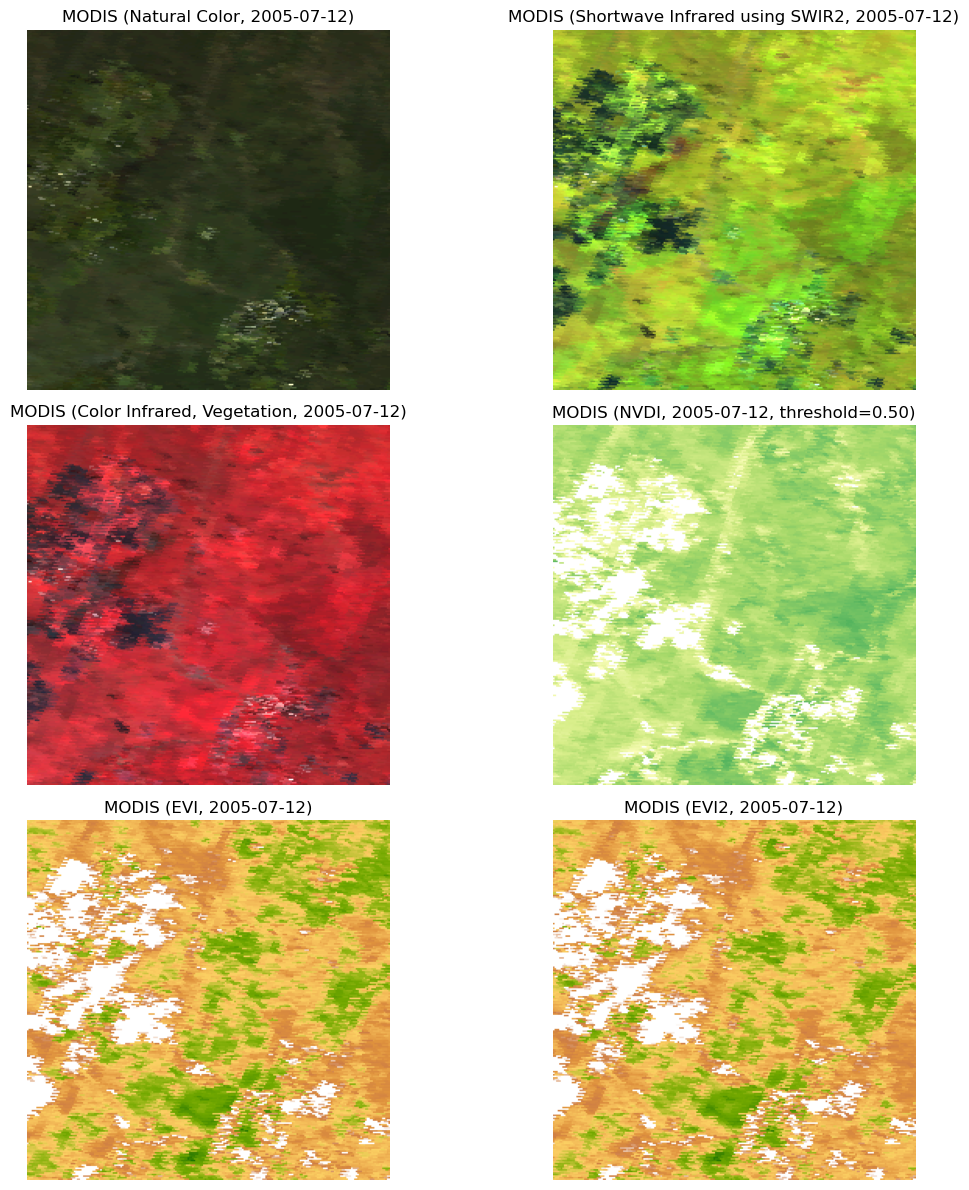

In [21]:
fig, axes = plt_pylab.subplots(3, 2, figsize=(15, 12))

for i, j in itertools.product(*[range(3)], *[range(2)]):
        
    adapter_ts.satimg_view_opt = lst_view_opt[2 * i + j]
    adapter_ts.showSatImage(IMG_ID, ax=axes[i][j], show=False)

### Fire Labels (MTBS)

In [22]:
WITH_UNCHARTED_AREAS=True

Start event: 'Processing fire labels (MTBS)'.
Finnish event: 'Processing fire labels (MTBS)'. It takes 0.00s.


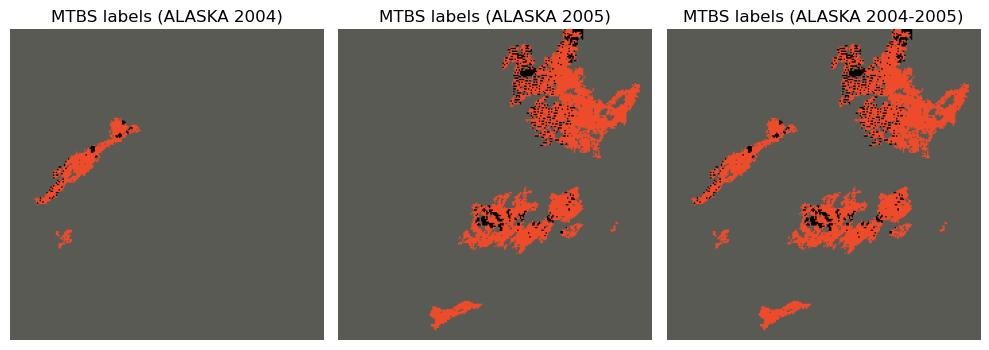

In [23]:
_, axes = plt_pylab.subplots(1, 3, figsize=(10, 12))

adapter_ts.showFireLabels(
    id_bands=0, figsize=(3.5, 3.5), show_uncharted_areas=WITH_UNCHARTED_AREAS, show=False, ax=axes[0]
)
adapter_ts.showFireLabels(
    id_bands=1, figsize=(3.5, 3.5), show_uncharted_areas=WITH_UNCHARTED_AREAS, show=False, ax=axes[1]
)
adapter_ts.showFireLabels(
    id_bands=range(0, 2), figsize=(3.5, 3.5), show_uncharted_areas=WITH_UNCHARTED_AREAS, show=False, ax=axes[2]
)

In [24]:
BRIGHTNESS_FACTORS=(7, 7)

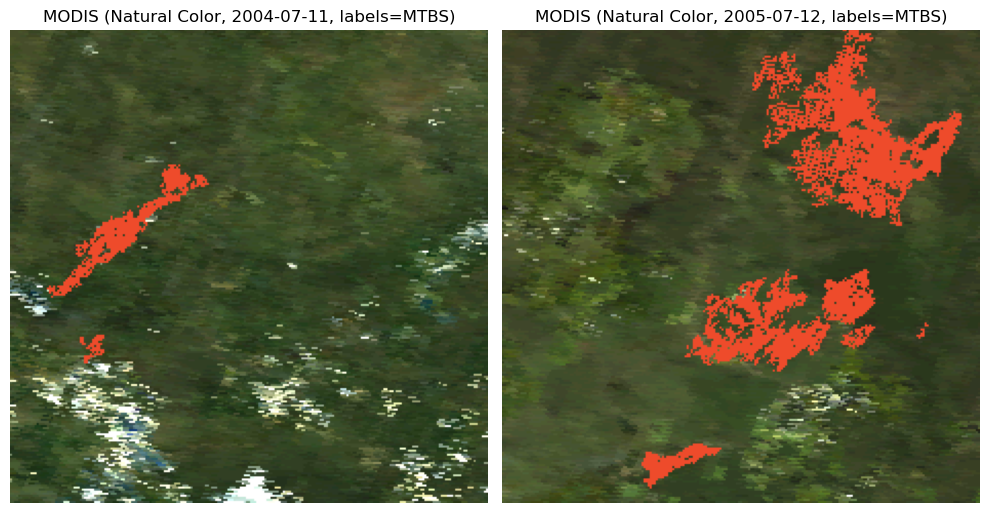

In [25]:
_, axes = plt_pylab.subplots(1, 2, figsize=(10, 10))

adapter_ts.satimg_view_opt = SatImgViewOpt.NATURAL_COLOR
adapter_ts.showSatImageWithFireLabels(
    id_img=24, brightness_factors=BRIGHTNESS_FACTORS, figsize=(3.5, 3.5), show=False, ax=axes[0]
)
adapter_ts.showSatImageWithFireLabels(
    id_img=70, brightness_factors=BRIGHTNESS_FACTORS,figsize=(3.5, 3.5), show=False, ax=axes[1]
)

## Creating data sets

In [26]:
id_start_date = 0
adapter_ts.ds_start_date = adapter_ts.satimg_dates.iloc[id_start_date]['Date']
print('Data set start date {}'.format(adapter_ts.ds_start_date))

Data set start date 2004-01-01


In [27]:
id_start_date = -1
adapter_ts.ds_end_date = adapter_ts.satimg_dates.iloc[id_start_date]['Date']
print('Data set end date {}'.format(adapter_ts.ds_end_date))

Data set end date 2005-12-27


In [28]:
adapter_ts.createDataset()

Start event: 'Standardize time series pixels using z-score'.
Finnish event: 'Standardize time series pixels using z-score'. It takes 1.83s.
Start event: 'Standardize time series pixels using z-score'.
Finnish event: 'Standardize time series pixels using z-score'. It takes 0.44s.
Start event: 'Standardize time series pixels using z-score'.
Finnish event: 'Standardize time series pixels using z-score'. It takes 0.16s.
Start event: 'Transforming data using PCA'.
PCA - cumulative explained variance, found 15 latent factors
PCA - cumulative explained variance, found 18 latent factors
PCA - cumulative explained variance, found 13 latent factors
PCA - cumulative explained variance, found 14 latent factors
PCA - cumulative explained variance, found 21 latent factors
PCA - cumulative explained variance, found 25 latent factors
PCA - cumulative explained variance, found 23 latent factors
PCA - cumulative explained variance, found 17 latent factors
PCA - cumulative explained variance, found 8 lat

In [29]:
ds_train = adapter_ts.getTrainingDataset()
ds_test = adapter_ts.getTestDataset()
ds_val = adapter_ts.getValidationDataset()

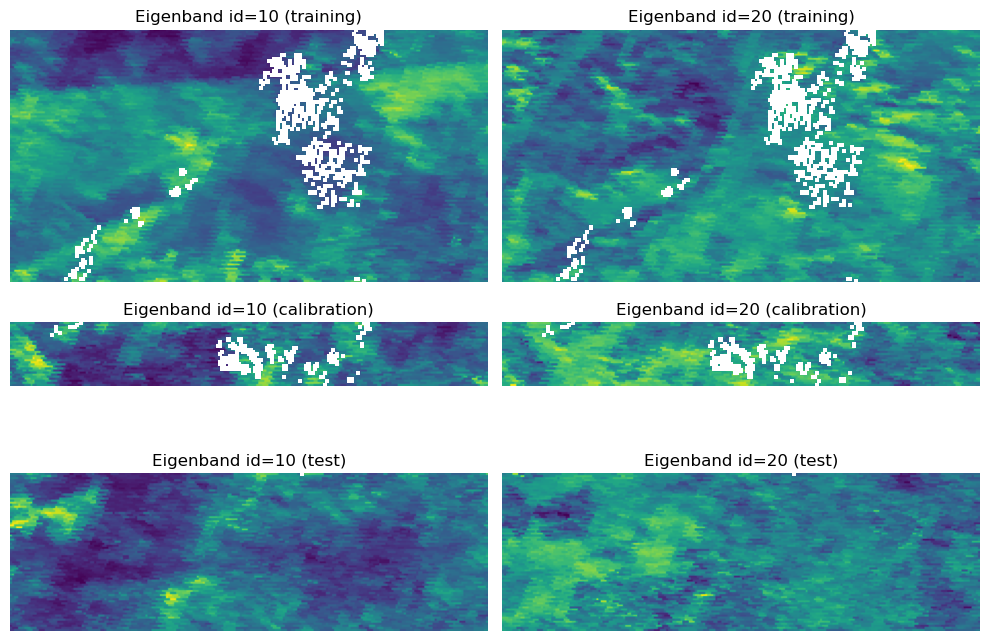

In [30]:
_, axes = plt_pylab.subplots(3, 2, figsize=(10, 7))

img_train = ds_train[0]
img_calib = ds_val[0]
img_test = ds_test[0]

plt_utils.imshow(img_train[:, :, 10], title='Eigenband id=10 (training)', ax=axes[0][0])
plt_utils.imshow(img_train[:, :, 20], title='Eigenband id=20 (training)', ax=axes[0][1])
plt_utils.imshow(img_calib[:, :, 10], title='Eigenband id=10 (calibration)', ax=axes[1][0])
plt_utils.imshow(img_calib[:, :, 20], title='Eigenband id=20 (calibration)', ax=axes[1][1])
plt_utils.imshow(img_test[:, :, 10], title='Eigenband id=10 (test)', ax=axes[2][0])
plt_utils.imshow(img_test[:, :, 20], title='Eigenband id=20 (test)', ax=axes[2][1])

## Save training and test data sets as the HDF5 files

In [31]:
DS_PREFIX = 'ak_modis_2004_2005_100km'
OUTPUT_H5_DIR = '../data/h5/mtbs'

In [32]:
FILE_FORMAT = io_utils.FileFormat.HDF5

Save a training data set as a HDF5 file. HDF5 is a hierarchical data format that is widely used in data science to store and manage large datasets.

In [33]:
fn_train = os.path.join(OUTPUT_H5_DIR, f'{DS_PREFIX}_probability_training.h5')
io_utils.saveDataset(ds_train, fn_train, FILE_FORMAT)

In [34]:
fn_calib = os.path.join(OUTPUT_H5_DIR, f'{DS_PREFIX}_probability_calib.h5')
io_utils.saveDataset(ds_val, fn_calib, FILE_FORMAT)

Save a test data set then.

In [35]:
fn_test = os.path.join(OUTPUT_H5_DIR, f'{DS_PREFIX}_probability_test.h5')
io_utils.saveDataset(ds_test, fn_test, FILE_FORMAT)

## Training using PermonSVM 

In [36]:
PERMON_SVM_DIR='/Users/marek/Playground/permon/permonsvm'

In [37]:
!cat runsvm_probability.sh

PERMON_SVM_DIR=$1
TOOLS_DIR=$2

DATA_DIR=${TOOLS_DIR}/data/h5/mtbs
OUTPUT_DIR=${TOOLS_DIR}/output/permonsvm

DS_PREFIX=ak_modis_2004_2005_100km

FN_TRAIN=${DATA_DIR}/${DS_PREFIX}_probability_training.h5
FN_CALIB=${DATA_DIR}/${DS_PREFIX}_probability_calib.h5
FN_TEST=${DATA_DIR}/${DS_PREFIX}_probability_test.h5

FN_TRAIN_PREDICTS=${OUTPUT_DIR}/${DS_PREFIX}_training_probability_predictions.h5
FN_TEST_PREDICTS=${OUTPUT_DIR}/${DS_PREFIX}_test_probability_predictions.h5

LOSS_TYPE=L1
MAT_TYPE=dense

${PERMON_SVM_DIR}/src/tutorials/ex5 \
-fllop_trace \
-f_training ${FN_TRAIN} -Xt_training_mat_type ${MAT_TYPE} -f_calib ${FN_CALIB} -Xt_calib_mat_type ${MAT_TYPE} \
-f_test ${FN_TEST} -Xt_test_mat_type ${MAT_TYPE} \
-svm_view_io \
-uncalibrated_qps_mpgp_expansion_type projcg -uncalibrated_qps_mpgp_gamma 10 -uncalibrated_qps_view_convergence \
-uncalibrated_svm_loss_type ${LOSS_TYPE} -uncalibrated_svm_binary_mod 2 -uncalibrated_svm_C 0.01 \
-svm_threshold 0.50 -tao_view \
-svm_view_report \
-f_tra

In [38]:
!sh runsvm_probability.sh {PERMON_SVM_DIR} {TOOLS_DIR}

 0 BEGIN FUNCTION SVMLoadTrainingDataset
SVM Object: 1 MPI process
  type: probability
  Mat Object: Xt_training_biased (Xt_training_biased_) 1 MPI process
    type: shell
    Samples are augmented with additional dimension by means of bias 1.00
    inner    Mat Object: Xt_training (Xt_training_) 1 MPI process
      type: seqdense
      samples	28027
      samples+	 4050 (14.45%)
      samples-	23977 (85.55%)
      features	  250 (251)
 0 END   FUNCTION SVMLoadTrainingDataset (0.11 s)
 0 BEGIN FUNCTION SVMLoadCalibrationDataset
SVM Object: 1 MPI process
  type: probability
  Mat Object: Xt_calib_biased (Xt_calib_biased_) 1 MPI process
    type: shell
    Samples are augmented with additional dimension by means of bias 1.00
    inner    Mat Object: Xt_calib (Xt_calib_) 1 MPI process
      type: seqdense
      samples	 7002
      samples+	 1535 (21.92%)
      samples-	 5467 (78.08%)
      features	  250 (251)
 0 END   FUNCTION SVMLoadCalibrationDataset (0.02 s)
 0 BEGIN FUNCTION SVMLoadT

## Result visualizations

In [39]:
SHOW_UNCHARTED_AREAS=True

In [40]:
fn_training_pred='../output/permonsvm/ak_modis_2004_2005_100km_training_probability_predictions.h5'
y_train_pred = permonsvm_io.loadResult(fn_pred=fn_training_pred, fn_mask=fn_train)

In [41]:
THRESHOLD = 0.5

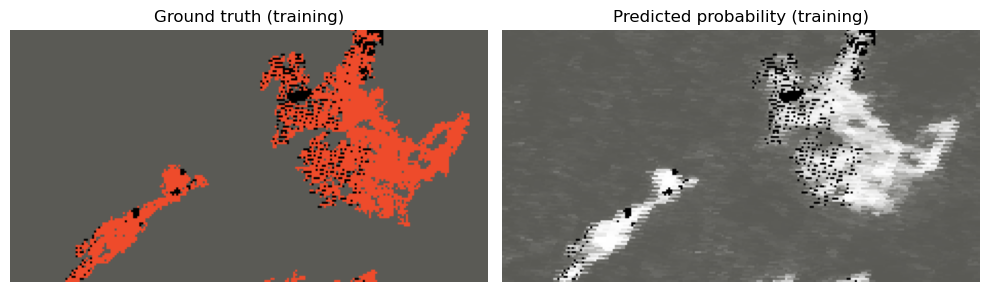

In [42]:
_, axes = plt_pylab.subplots(1, 2, figsize=(10, 9))

plt_utils.labelshow(
    ds_train[1], 
    with_uncharted_areas=SHOW_UNCHARTED_AREAS, 
    title='Ground truth (training)',  
    ax=axes[0],
    show=False
)

plt_utils.labelshow_prob(
    y_train_pred,
    title='Predicted probability (training)',
    ax=axes[1],
    show=False
)

plt_pylab.show()

In [43]:
y_train_pred[y_train_pred >= THRESHOLD] = 1
y_train_pred[y_train_pred < THRESHOLD] = 0

Classification report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     23977
         1.0       0.89      0.72      0.80      4050

    accuracy                           0.95     28027
   macro avg       0.92      0.85      0.89     28027
weighted avg       0.95      0.95      0.95     28027


Classification report (imbalanced):

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.95      0.99      0.72      0.97      0.84      0.73     23977
        1.0       0.89      0.72      0.99      0.80      0.84      0.70      4050

avg / total       0.95      0.95      0.76      0.95      0.84      0.73     28027


IoU- (intersection over union): 0.94

IoU+ (intersection over union): 0.67

mIoU (mean IoU): 0.80




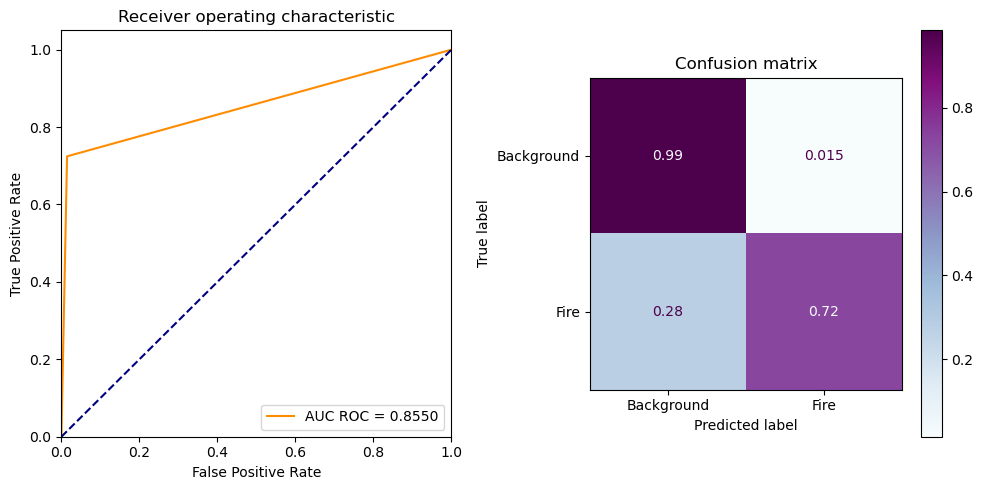

In [44]:
labels_pred = utils_report.show_report(
    labels_true=ds_train[1],
    labels_pred=y_train_pred,
    with_aucroc=True,
    with_cmat=True,
    with_report=True
)

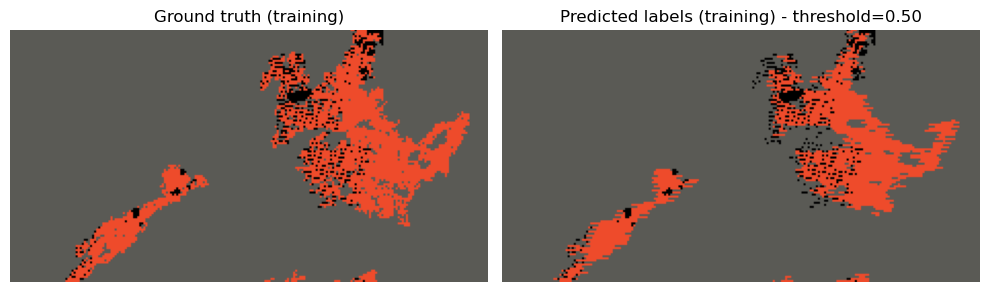

In [45]:
_, axes = plt_pylab.subplots(1, 2, figsize=(10, 9))

plt_utils.labelshow(
    ds_train[1], 
    with_uncharted_areas=SHOW_UNCHARTED_AREAS, 
    title='Ground truth (training)',  
    ax=axes[0],
    show=False
)

plt_utils.labelshow(
    y_train_pred,
    with_uncharted_areas=SHOW_UNCHARTED_AREAS,
    title='Predicted labels (training) - threshold={:.2f}'.format(THRESHOLD),
    ax=axes[1],
    show=False
)

plt_pylab.show()

In [46]:
fn_test_pred='../output/permonsvm/ak_modis_2004_2005_100km_test_probability_predictions.h5'
y_test_pred = permonsvm_io.loadResult(fn_pred=fn_test_pred, fn_mask=fn_test)

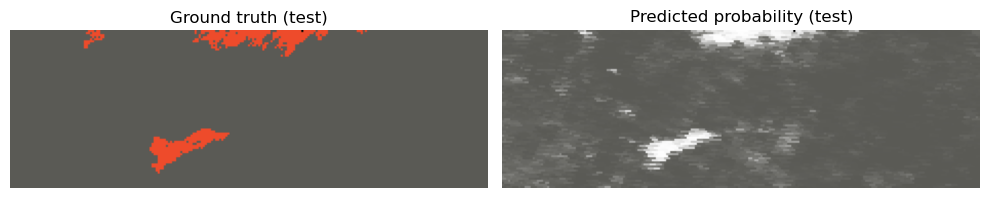

In [47]:
_, axes = plt_pylab.subplots(1, 2, figsize=(10, 9))

plt_utils.labelshow(
    ds_test[1], 
    with_uncharted_areas=SHOW_UNCHARTED_AREAS, 
    title='Ground truth (test)',  
    ax=axes[0],
    show=False
)

plt_utils.labelshow_prob(
    y_test_pred,
    with_uncharted_areas=SHOW_UNCHARTED_AREAS,
    title='Predicted probability (test)',
    ax=axes[1],
    show=False
)

plt_pylab.show()

In [48]:
y_test_pred[y_test_pred >= THRESHOLD] = 1
y_test_pred[y_test_pred < THRESHOLD] = 0

Classification report:

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     17223
         1.0       0.88      0.69      0.77       717

    accuracy                           0.98     17940
   macro avg       0.93      0.84      0.88     17940
weighted avg       0.98      0.98      0.98     17940


Classification report (imbalanced):

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.99      1.00      0.69      0.99      0.83      0.71     17223
        1.0       0.88      0.69      1.00      0.77      0.83      0.66       717

avg / total       0.98      0.98      0.70      0.98      0.83      0.70     17940


IoU- (intersection over union): 0.98

IoU+ (intersection over union): 0.63

mIoU (mean IoU): 0.81




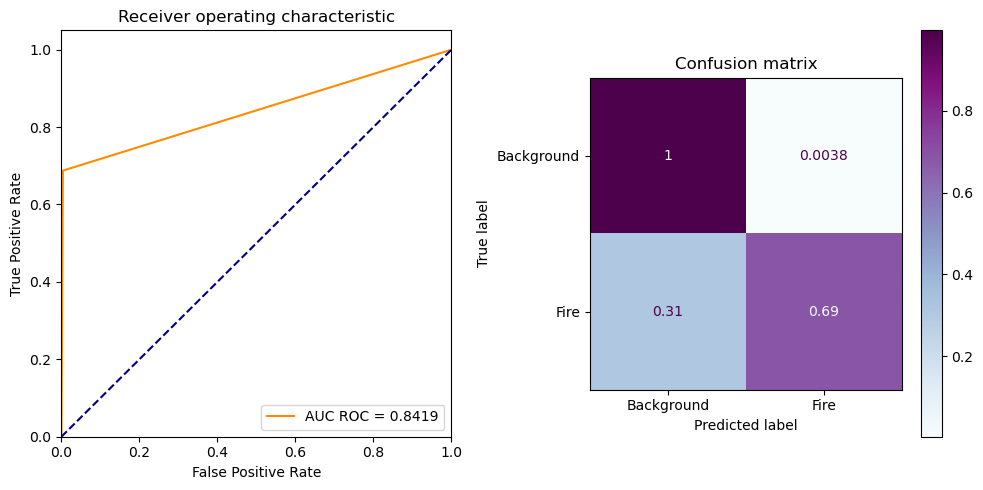

In [49]:
labels_pred = utils_report.show_report(
    labels_true=ds_test[1],
    labels_pred=y_test_pred,
    with_aucroc=True,
    with_cmat=True,
    with_report=True
)

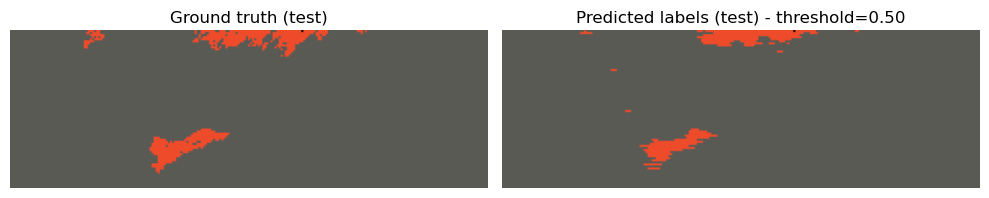

In [50]:
_, axes = plt_pylab.subplots(1, 2, figsize=(10, 9))

plt_utils.labelshow(
    ds_test[1], 
    with_uncharted_areas=SHOW_UNCHARTED_AREAS, 
    title='Ground truth (test)',  
    ax=axes[0],
    show=False
)

plt_utils.labelshow(
    y_test_pred,
    with_uncharted_areas=SHOW_UNCHARTED_AREAS,
    title='Predicted labels (test) - threshold={:.2f}'.format(THRESHOLD),
    ax=axes[1],
    show=False
)

plt_pylab.show()